# <u>Building a Neural Network from Scratch: MNIST Digit Classifier</u>

This notebook walks through the <b>entire process of building a neural network from scratch</b> - without using high level libraries such as Tensorflow or PyTorch. 

We shall train our model on the <b>MNIST handwritten digit dataset</b>, which contains greyscale images of digits from 0 to 9. Each image is a $28 \times 28$ pixel image which is a total of 784 pixels per image. 10000 such images are then stored as a 2D matrix with 10000 rows and 785 columns (1 column is for the labels and the others carry the pixel values). The goal is to build a basic image classifier that can recognize these digits.

#### What makes this project different?

- Every single line is hand coded so that we gain a comprehensive understanding of what is going on under the hood.
- Forward and Backpropagation is implemented from first principles.
- Exploration of the roles of weights, biases, activation functions, and loss functions.

This has also been a log of my journey attempting to learn machine learning and how to build a neural network.

By the end, this notebook should provide you with the following:

- A working neural network
- A comprehensive understanding about the interior of a neural network and how they learn
- A good foundation to build more complex neural networks

---

---

### Loading Data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

check_data = pd.read_csv('/home/niranjanharishankar/ML/DATASETS/mnist_test.csv')
print(check_data.head())

data = np.loadtxt('/home/niranjanharishankar/ML/DATASETS/mnist_test.csv', delimiter = ',', skiprows = 1)

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      2    0    0    0    0    0    0    0    0    0  ...      0      0   
2      1    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]


---

Here the delimiter defines how each column separated. For CSV files, the delimiter is a comma ( , ).

The skiprow is done so that while reading, the first row is skipped. The first row often contains the column headings and is therefore omitted as it is unnecessary. I have verified it, nevertheless.

---

### Normalization

In [26]:
x = data[:,1:]   #all columns except the first column
y = data[:,0]   #first column is the label

print(x.shape)
#we now normalize the data"

x = x / 255.0

print("Min pixel value in  set:", x.min())
print("Max pixel value in  set:", x.max())

(10000, 784)
Min pixel value in  set: 0.0
Max pixel value in  set: 1.0


---

We normalize the data for the following reasons:

- helps the neural network learn faster
     * neural networks work best when the inputs are in a similar, small range
     * large inputs like 255 can lead to large activations, which can lead to unstable gradients, which in turn may lead to slower or failed        training
- prevents numerical instability
     * for large inputs, exponents may explode (softmax)
     * avoids overflow (very huge number)
- gradient descent becomes smoother
     * features of different scales confuse optimizer
     * normalized data helps gradient to point in the right direction consistently

We have performed a simple check on the normalized dataset and we see that the minimum is 0 and the maximum is 1, as intended.

---

### Test/Train Split

In [31]:
#shuffle the indices first
indices = np.arange(x.shape[0])   #1
np.random.seed(42)   #2
np.random.shuffle(indices)   #3

#we now shuffle the dataset
x = x[indices]   
y = y[indices]

#split the dataset that has been shuffled
x_train, x_test = x[:6000], x[6000:]
y_train, y_test = y[:6000], y[6000:]

In [32]:
print(x_train.shape)

(6000, 784)


---

We need to establish a few things. Why do we need to split the dataset? 

When we split the dataset, we create two sets:

- Training set
   * Used to train the model
- Testing set
   - Used to evaluate the performance of the data on unseen dataset

We cannot train and test on the same dataset because if we do that, it will appear as though the model is performing extremely well. As though it has memorize. This is called <u><b>overfitting</b></u>. In order to test its learning capability, we test it on new data it has not seen yet. We can gauge accurately how well it is performing in this manner. 

Now, why do we need to shuffle the rows? 

The data might be ordered and this will mess up the training. If the data is ordered, the model essentially sees only one digit type at a time. This makes learning difficult and slow


I shall now perform rubber ducking on the above segment.

1. We create a list of numbers with 10000 elements. This shall be from 0 all the way up to 9999
2. Here, we use the seed as sort of a password. When we randomize, we would like the same order of random numbers every time we run. Hence,     we use 42. We may use any integer as each integer houses a particular order of shuffling. The shuffling is therefore pseudo-random.
3. We simply shuffle the indices.

When we use the shuffled indices inside the arrays below, we end up shuffling the contents inside it.

---

### Visualization

In [37]:
def show_image(index, dataset = 'train'):
    if dataset == 'train':
        image = x_train[index].reshape(28,28)
        label = y_train[index]
    else:
        image = x_test[index].reshape(28,28)
        label = y_test[index]

    plt.imshow(image, cmap='grey')
    plt.title(f'Label = {label}')
    plt.axis('off')
    plt.show()

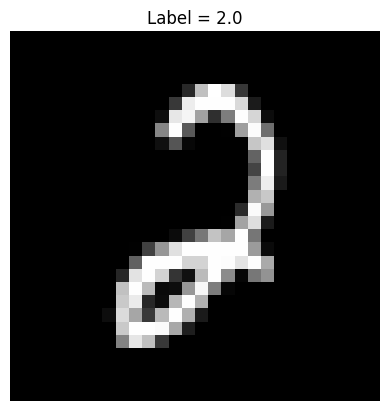

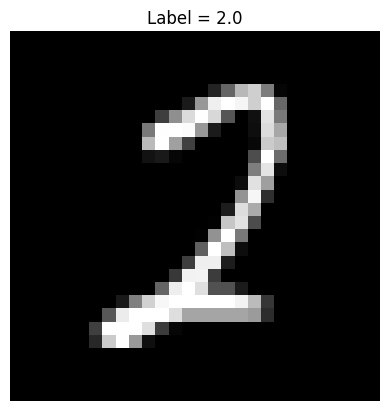

In [38]:
show_image(1)

show_image(2333, 'test')

---

We define a function <b>show_image()</b> in order to visualize our data and understand what we are dealing with.

The function is defined with two arguments, index and the dataset. The dataset has been set to train as default. If we do not pass any argument which changes the default dataset from train, the if condition is satisfied and the row corresponding to the passed index is called. The row matrix of <b>784 elements</b> are of no use to the human eye, hence we reshape it to a <b>28 x 28 2D array</b>. We then pass the value in the y_train matrix which contains the label, i.e. the number. 

If we pass an argument which says that the dataset to be used is the test dataset, we bypass the if condition and the else condition is called. What happens within the else block is similar to the if block. 

All we have done so far is to reshape the <b>1D array of 784 elements</b> to a <b>2D array of dimensions 28 x 28</b> and assign the label value to the variable label. We then plot it. You may look above to see how it works. This function may prove useful later on if/when we need to verify the predictions made by the model.

---

Given below are a few tests done to see if all is well and good.

#### 1. Label Check

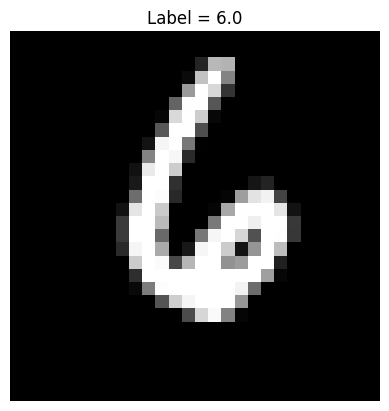

Expected Label: 6.0


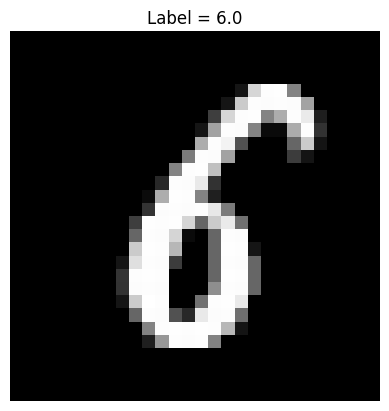

Expected Label: 6.0


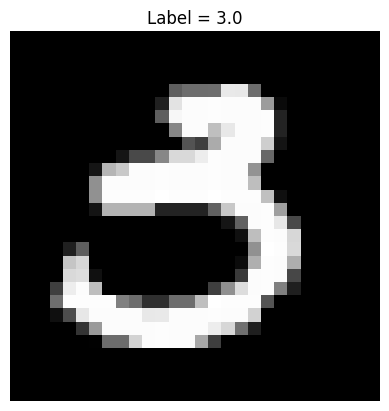

Expected Label: 3.0


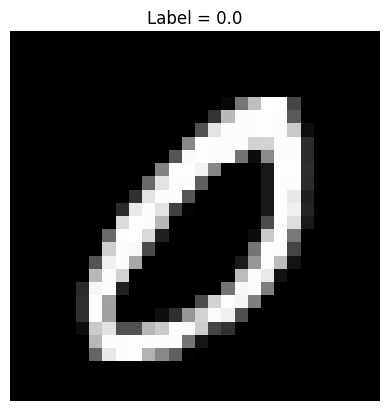

Expected Label: 0.0


In [44]:
# Pick a few indices randomly
for i in [0, 10, 42, 99]:
    show_image(i, dataset='train')
    print("Expected Label:", y_train[i])


We establish with sufficient confidence that the label matches with the digit shown in the image. 

#### 2. Sanity Check

A simple sanity test to see if the normalization worked has been performed. 

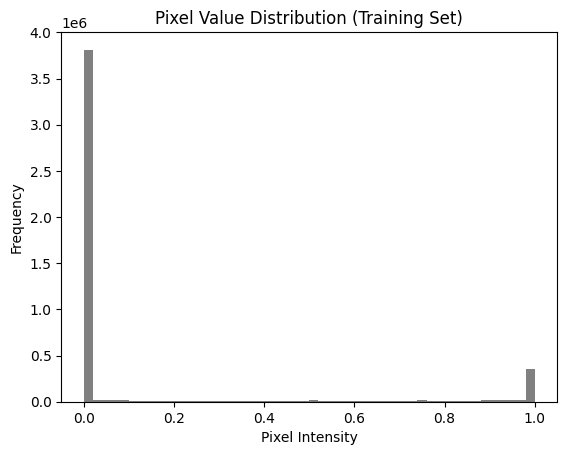

In [48]:
plt.hist(x_train.flatten(), bins=50, color='gray')
plt.title("Pixel Value Distribution (Training Set)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

It is evident from the histogram that the pixel intensity values lie between the minimum value 0 and the maximum value 1. Thus, we can establish with sufficient confidence that the normalization has indeed worked properly.

A test for normalization has been done previously when we called from the maximum and minimum for the x dataset.

---

### One-Hot Encoding the Labels

<b>Why One-Hot Encoding?

When training a neural network, we want the output to match your target. But the labels  3, 7, 0 etc. are simply integers. In a neural network, the output of the model is a vector and thus we want our targets to be vectors as well.

The expected output of a model would be:   
[0.05, 0.01, ..., 0.92, ..., 0.03] ← Model’s prediction (probability-like)

What we need our target to be is:  
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0] ← If the digit is a 7

We can see that the 7th element is 1 in the above array. This indicates the class 7. That is what one-hot encoding does for us. A way to say 'this is class 7' in a manner compatible with the model's output layer (layer of the neural network making the prediction).

---

In [54]:
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((len(y), num_classes))   #creates an array with 10 columns and as many rows as there are labels
    for i, val in enumerate(y):
        one_hot[i, int(val)] = 1
    return one_hot

---

Algorithm followed above:  

1. Create a function that takes the array of labels y and assumes there are 10 classes.
2. Create an array that has as many rows as there are labels and 10 columns. If we take the y_train dataset, we will get an array of shape      (6000, 10).
3. We loop through each label in y, keeping track of the index i and the label val itself.
4. Now, we go to row i and set column val to 1.
    - eg: if i = 0 and val = 3, we can know that the zeroth row, the label is 3 and therefore the element at index 3 would be equal to 1.  
      [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] <- array corresponding to label 3

We then apply it to y_test and y_train.

Note: we have cast val as int above. This was done because the index must be an integer and apparently, val was not.

---

In [58]:
#one hot encoding
y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

In [59]:
#Sanity Check for the one-hot encoding
print(f'Label: {y_train[0]}')
print(f'Label of the encoded array: {y_train_encoded[0]}')

Label: 6.0
Label of the encoded array: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


---

### Inititalizing Weights and Biases

Let us first begin with the sizing of the layers:

1. Input layer : 784 units (28x28 pixels)
2. Hidden layer : 64 units (arbitrary reasonable choice)
3. Output layer : 10 units (0 to 9)

The obvious question here is why there are 64 units in the hidden layer. It is completely arbitrary. We choose a small enough number to train quickly but big enough to learn useful features.

Factors that influence the choice
- Input size: We have 784 inputs, so 32-128 units is a common range.
- Output size: We need to map to 10 classes. So the hidden layer must be capable of extracting patterns in order to differentiate between      them.
- Computing capability and speed: More neurons mean slower training. We do not want that to happen when we are testing and experimenting. So   we start low.
- Overfitting risk: More units mean more parameters and as a result more chances to overfit.

In short, there are a whole lot of factors that influence the size of the hidden layer. <i>So how do we predict how many units to use?</i> The answer is, <i>we do not</i>. In the real world, we try out different numbers and we pick the one which gives us the best result.

---

In [63]:
#layer sizes
input_size = 784
hidden_size = 64
output_size = 10

#seed for reproducability
np.random.seed(42)

#initializing weights and biases
w1 = np.random.randn(hidden_size, input_size) * 0.01
b1 = np.zeros((hidden_size, 1))

w2 = np.random.randn(output_size, hidden_size) * 0.01
b2 = np.zeros((output_size, 1))

---

#### Why do we use the seed again?

We do not want a different order of random numbers every single time. If that happens, there wouldn't be any learning happening. It would just end in chaos. We need reproducability because what we are doing is experimental.

### Weights

Weights tell the neural network which pixels are more important. In a general sense, it tells the network how stongly to consider each input. For each input, there will be an assigned weight. We take the weighted sum which gets passed into the activation function. We multiply it by 0.01 in order to keep the weights small. If we initialize without scaling, the input of the activation function may be large and this will cause the vanishing gradient problem. For example, say you initialize it without scaling, some weight might be some large value like 5 or -6. If we compute the weighted sum using these weights, we might get a large value, say +/-1000. If this goes into the sigmoid function, it will give out either 0 or 1.

$$
sigmoid(-1000) \approx 0
$$                                                       
$$
sigmoid(+1000) \approx 1
$$
If the weighted sum is zero, the gradient becomes zero and the learning stops. 

Without weights, the neural network would simply be averaging all the inputs. The weights give them the <i>intelligence</i>.


#### What are we actually doing during training?

1. Start with random weights
   * We don't know which pixels (inputs) are important, so we make a guess.
2. Make predictions using these weights
   * Inputs and weights to give output
3. Compare prediction to the true value (Loss function)
   * If prediction is wrong, the loss would be high
   * It tells us how bad our current weights are
4. Adjust weights to minimise the loss (back propagation and gradient descent)
   * Figure out which weights caused the mistake and how they must change
   * Update weights to make better predictions

In short, training the model is finding the best possible weights. 

#### Why is the dimension of the weights matrix 64 x 784?

Each neuron in the layer takes all the inputs and applies its own set of weights. So, each neuron has a row vector of weights (1 x input_size). Now, we have such row vectors for every neuron. If we stack the row vectors for each matrix, we get hidden_size rows and input_size columns. Thus we have a matrix of dimension 64 x 784. 

---

### Forward Propagation

This step takes the flattened image (input) and passes it through a hidden layer where we:
- apply weights and biases
- ReLU activation

Then we pass it through an output layer where we:
- apply weights and biases again
- softmax activation to output probabilities



---

In [70]:
def relu(z):
    return np.maximum(0, z)

def softmax(z):
    exp_z = np.exp(z-np.max(z)) #stability test
    return exp_z / np.sum(exp_z, axis = 0, keepdims = True) 


def forward_prop(x1, w1, w2, b1, b2):
    #Hidden Layer
    z1 = np.dot(w1, x1) + b1
    a1 = relu(z1)

    #Output Layer
    z2 = np.dot(w2, a1) + b2
    a2 = softmax(z2)
    #print(a2.shape)
    return z1, a1, z2, a2

---

In [72]:
# Pick a sample image
x_sample = x_train[0].reshape(-1, 1)  # shape: (784, 1)

# Run forward pass
z1, a1, z2, output_probs = forward_prop(x_sample, w1, w2, b1, b2)

# Get predicted digit
predicted_digit = np.argmax(output_probs)
print("Predicted:", predicted_digit)
print(y_train[0])


Predicted: 0
6.0


In [73]:
correct = 0

for i in range(10):
    x_i = x_test[i].reshape(784, 1)
    y_i = y_test[i]

    z1, a1, z2, predickshun = forward_prop(x_i, w1, w2, b1, b2)

    pred = np.argmax(predickshun)

    print(f"Image {i} → Prediction: {pred}, Actual: {y_i}")
    if pred == y_i:
        correct += 1

print("Accuracy on first 10 samples:", correct, "/ 10")


Image 0 → Prediction: 5, Actual: 7.0
Image 1 → Prediction: 9, Actual: 5.0
Image 2 → Prediction: 9, Actual: 4.0
Image 3 → Prediction: 5, Actual: 9.0
Image 4 → Prediction: 9, Actual: 6.0
Image 5 → Prediction: 9, Actual: 7.0
Image 6 → Prediction: 9, Actual: 8.0
Image 7 → Prediction: 5, Actual: 2.0
Image 8 → Prediction: 9, Actual: 4.0
Image 9 → Prediction: 5, Actual: 3.0
Accuracy on first 10 samples: 0 / 10


---

Given above are two code blocks which use the forward propagation alone to predict the samples. It is giving the wrong answer, as it should because the weights are random, and the network hasn't been <i>trained</i> yet. It has no idea how to map inputs to correct outputs. So, at this point the network is simply <i>guessing</i>.


### ReLU (Rectified Linear Unit)

ReLU is sort of like a gate which looks at the input value and gives out either the input if the input is greater than zero, or zero if the input is negative.

$$
\text{ReLU}(z) = \max(0, z)
$$
$$
if\: z <  0,\: then\: \text{ReLU}(z) = 0
$$
$$
if\: z \geq 0,\: then\:  \text{ReLU}(z) = z
$$

#### Why is it used?

- Fast to compute: no exponents or arithmetic involved
- Avoids vanishing gradients: does not squash large values like the sigmoid or tanh function
- Sparse activation: sets most of the inputs to zero, i.e. those that are negative.

Negative inputs basically tell us that the pattern we are looking for does not exist in that input. So, we can safely <i>turn off</i> that neuron for that input. This selective activation encourages sparsity, which improves learning efficiency and decreases overfitting. The other neurons will respond to other parts of the circuit as per usual. In this manner, ReLU allows for the network to focus on what is important or what <i>matters most</i> for the given input while still covering the full range of features across all neurons.

### Softmax

Given a vector of scores: $ {z} = [z_1, z_2, \dots, z_K] $ for $ K $ classes, Softmax is defined as:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

for each $( i = 1, 2, \dots, K )$.

Softmax takes the values given to it and churns out a probability distribution. The output:
- lies between 0 and 1
- sums to 1
- can be interpreted as a probability for each class

#### What is happening here?

When you exponentiate the scores, it magnifies the differences (larger values dominate). Now, when you divide the whole thing by the sum of the exponentials, you normalize it and as a result the outputs add up to 1. In this manner, the softmax converts the raw output of the model (logit) into a form that is interpretable and also show us how confident the model is. A way of imagining this would be that the output would be like the model is saying, <i>"I am 80% sure that this number is 4, but it could also be 7."</i>



                                                       

---

### Cross-Entropy Loss Function

At its core, the cross-entropy loss function measures the difference between two probability distributions: the predicted distribution from the model and the actual distribution often seen as the one-hot encoded vector. Intuitively, the cross-entropy loss quantifies how surprised the model is by the prediction. If the loss is small, then the prediction is actually quite close to the true value. If the loss is high however, the prediction is very far from the true value. 

The cross-entropy loss function is given as:

$$
\text{Loss} = - \sum_i y_i \log(\hat{y}_i)
$$

here $y_i$ is the true label (1 for the correct class and 0 for others) and $\hat{y}_i$ is the model's predicted probability for class $i$. Since only one class has $y_i = 1$, the equation simplifies to  $-  \log(\hat{y}_{correct\: class})$

This particular method is especially useful when used in association with softmax.


---

In [79]:
def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[1]
    epsilon = 1e-9
    return -np.sum(y_true * np.log(y_pred + epsilon)) / m

In [80]:
i=0
y_true = y_train_encoded[[i], :]
loss = cross_entropy_loss(output_probs, y_true.T) #y_true has shape (1,10) and we need (10,1)
print(f'Loss = {loss}')

Loss = 2.3081151848866805


---

### What is the code doing?

To get the predicted values, I used the output from the previous section of the code where we did the forward propagation. The real value was obtained from the one-hot encoded data that was prepared previously. Using these, we calculated the loss function. 
The label vector was shaped as a row vector and therefore we applied a transpose on it.

---

I am going to take a minute to list out all the symbols and variables listed out:

- x               : input                                    : (10000, 784)
- x_train         : split for training                       : (6000, 784)
- x_test          : split for testing                        : (4000, 784)
- y               : label matrix                             : (10000,1)
- y_train_encoded : one-hot encoded matrix for train dataset : (6000, 784)
- y_test_encoded  : one-hot encoded matrix for test dataset  : (4000, 784)
- w1              : weights from input to hidden             : (64, 784)
- b1              : bias from input to hidden                : (64, 1)
- z1              : pre-activation for hidden                : (64, 1)
- a1              : output from hidden layer                 : (64, 1)
- z2              : pre-activation for output before softmax : (10, 1)
- w2              : weights from hidden to output layer      : (10, 64)
- b2              : bias from hidden to output layer         : (10, 1)
- a2              : output after softmax                     : (10, 1)


---

### Backpropagation

#### Compute Loss Derivative w.r.t Softmax Output (Output Layer)

Backpropagation is an algorithm used to calculate the gradients of the loss function with respect to all weights and biases of the network. We do this in order to figure out which direction to nudge our weights in order to minimize the loss function. These gradients are then used to update the weights by <b>gradient descent.</b>

We remember that the loss function is:
$$
\text{Loss} = - \sum_i y_i \log(\hat{y}_i)
$$

The derivative of this loss function is:
$$
\frac{\partial L}{\partial z_2} = a_2 - y
$$

This gradient tells use how much changing values in $z_2$ will affect the loss. In the next step, we look towards the gradients with respect to the weights and biases from the hidden layer to the output layer. 

#### Backprop to $W_2$ and $b_2$

$$
\frac{\partial L}{\partial w_2} = \frac{\partial L}{\partial z_2} \cdot \frac{\partial z_2}{\partial w_2}
$$

Since $z_2 = w_2a_1$, we can say that $\frac{\partial z_2}{\partial w_2} = {a_1}^T$

Therefore, 

$$
\frac{\partial L}{\partial w_2} = (a_2 - y) \cdot {a_1}^T
$$

Next, the gradient with respect to bias is,

$$
\frac{\partial L}{\partial b_2}=\frac{\partial L}{\partial z_2} = a_2 - y
$$

To summarize,
$$
\frac{\partial L}{\partial w_2} = (a_2 - y) \cdot {a_1}^T
$$
$$
\frac{\partial L}{\partial b_2} = a_2 - y
$$

Training a neural network is teaching it how to connect inputs to outputs by adjusting the weights and biases. The weights between the hidden layer and the output layer $(w_2)$ is responsible for mapping the hidden layer activations to the final layer predictions. The difference between what the model predicted and what the correct label was that is, $(a_2 - y)$ represents the error at each output neuron. A larger error means that the contribution of that specific neuron was more incorrect, therefore the weights leading to it needs adjustment more significantly. But not all hidden neurons contributed equally to the error: some were more active than the others. If a hidden neuron was more active (its output in $a_1$ must be large), it played a bigger role in generating the incorrect prediction, so the update to the weights connected must be larger. So, the adjustment to each weight is determined by both the error <i>(how wrong the prediction was)</i> and its activation <i>(how strongly the hidden neuron contributed to that prediction).</i> As you can see above, the weight update formula is essentially an outer product of these two factors, enabling us to tweak each connection based on how much involved it was in the mistake.

#### Backpropagation through ReLU to Hidden Layer

We will now compute the gradient of the loss with the weights and biases from the first layer ($w_1\:and\:b_1$), so that we can update them to make the network learn better.

We'll apply the chain rule to find 

$$
\frac{\partial L}{\partial w_1}
$$

In order to do that we need to find 

$$
\frac{\partial L}{\partial z_1}
$$

We have,
$$ 
z_1 = w_1x + b_1
$$

$$
a_1 = ReLU(z_1)
$$

$$
a_2 = softmax(w_2a_1 + b_2)
$$

To get to $\frac{\partial L}{\partial z_1}$, we use,

$$
\frac{\partial L}{\partial z_1} = ({w_2}^T \cdot {\frac{\partial L}{\partial z_2}})\circ {ReLU'(z_1)}
$$
<n>
1. $({w_2}^T \cdot {\frac{\partial L}{\partial z_2}})$
   
   - This term pushes the output layer back into the hidden layer
   - It is like asking how much did each unit contribute to the final error
   - Shape: $w_2$ has the shape $10\times64$. Then its transpose will have shape $64\times10$. With it we are multiplying a $10\times1$    vector. So the result is a $64\times1$ vector.

2. $ {ReLU'(z_1)}$

    - This is the derivative of $ReLU$ - it is 1 when $z_1 > 0$ and 0 elsewhere.
    - So we multiply elementwise with the above result
    - This is why $ReLU$ helps with sparse gradients. Only those neurons that gave out positive input during forward pass gets updated.

3.  Final result

$$
\frac{\partial L}{\partial z_1} = a\: vector\: of\: shape\: (64,1)
$$

The weight gradient therefore is,

$$
\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial z_1} \cdot {x^T}
$$

This is a vector of shape $64\times784$.

For bias,
$$
\frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial z_1}
$$

This is a vector of shape $64\times1$

---

In [90]:
def relu_derivative(z):
    return (z > 0).astype(float)

---

The derivative of $ReLU$ has been dealt with already so we need not go into that again.

---

In [93]:
#backward propagation and parameter updation for one training example
def train_one_sample(x, y_true, w1, w2, b1, b2, lr):
    #forward propagation
    z1, a1, z2, a2 = forward_prop(x, w1, w2, b1, b2) #unpacking

    #calculating loss
    loss = cross_entropy_loss(a2, y_true)
    #print(f'Loss = {loss:.4f}')

    #backward pass
    delta2 = a2 - y_true    #output error
    dw2 = delta2 @ a1.T
    db2 = delta2

    delta1 = (w2.T @ delta2) * relu_derivative(z1)
    dw1 = delta1 @ x.T
    db1 = delta1

    #update parameters
    w2 -= lr * dw2
    b2 -= lr * db2
    w1 -= lr * dw1
    b1 -= lr * db1

    return loss

---

Now, in the above code block we have defined a function which updates the weights and biases by performing forward propagation, calculating loss and then doing backward propagation. This is what training on a single sample looks like.

We pass in x which is a column vector $(784 \times 1)$ and its correct label y_true $(10 \times 1)$ which is the one hot vector. We are updating the parameters $w_1,\: w_2,\: b_1,\: $and$\:b_2$ using backpropagation and gradient descent.

Everything else is pretty straightforward and all the math done has been discussed above.

---

Sample usage of the function train_one_sample. 

In [95]:
'''
#sample usage
i = 0
x = x_train[i].reshape(-1,1)
y_true = y_train_encoded[[i], :].T

loss = train_one_sample(x, y_true, w1, w2, b1, b2, lr = 0.01)
'''

'\n#sample usage\ni = 0\nx = x_train[i].reshape(-1,1)\ny_true = y_train_encoded[[i], :].T\n\nloss = train_one_sample(x, y_true, w1, w2, b1, b2, lr = 0.01)\n'

---
### Training

The below function <b>compute_accuracy</b> is a function that checks how good the neural network is at classifying data accurately. We define a counter variable which is later updated inside the loop every time the prediction made matches with the corresponding label.
The variable total is used to figure out how many images are there in the dataset. Now we go through the images one by one and check if the model predicts the correct digit.
x_data is then reshaped. The command used x_data[i].reshape(-1, 1) converts the given array into a column vector. When we pick out x_data[i] we essentially take out a row from the 2D array, i.e. one single image. We then have to convert that array into a column vector which is what we are doing in this step. 
We then pick out the label for the $i^{th}$ sample and save it as y_true with the shape (1, 10)

We perform forward propagation using the weights and biases provided to us after backpropagation. You might find that confusing as we are yet to perform backpropagation on the whole sample. This function is called later on after we are done training the whole dataset. It would be wise to remember that this function has a singular goal, which is to calculate the accuracy of our model and then return it.

np.argmax() returns the index of the maximum value in an array. For np.argmax(output_prob) the value that it spits out would be the index of the maximum value in the array of probabilities. This value is then stored in the predicted_class. Then, same is done for y_true which is the one-hot encoded array which has all but one entry that is 1. The index of that element is the actual label of that image.

Then these two values are compared, the prediction with the true value, and if they are equal the counter is incremented by 1.

The accuracy would be calculated as the total number of correct predictions made in the whole of the dataset, i.e. ratio of number of correct predictions to total number of elements.

---

In [98]:
def compute_accuracy(x_data, y_data_encoded):
    correct_predictions = 0  #counter
    total = x_data.shape[0]

    for i in range(total):
        x_sample = x_data[i].reshape(-1, 1) #shape (784, 1)
        y_true = y_data_encoded[[i], :] #shape (1, 10)

        z1, a1, z2, output_prob = forward_prop(x_sample, w1, w2, b1, b2)
        predicted_class = np.argmax(output_prob) #index of the largest probability value
        actual_class = np.argmax(y_true)  #index of the largest value, 1

        if predicted_class == actual_class:
            correct_predictions +=1

    accuracy = correct_predictions/total

    return accuracy

---
Now we go into the part where we train for the whole dataset. We initialize certain variables, let us first understand what they are.

1. Epoch: One complete pass through the entire dataset. Here we do 20 such passes.
2. Learning Rate: It decides how much the weights get updated during training in response to the estimated error. The lower the learning rate, the slower is the learning.

Now we iterate through each epoch. We set the value of total loss to be zero. Now, in the first epoch, we go through each image. We reshape the image into a column vector and same for the encoded lables. We calculate the loss by calling the function train_one_sample. This function will perform forward propagation by calling the relevant function, calculate loss by calling the relevant function, and perform back propagation and update the values for the weights and biases for one image and after which it returns the loss. Since it is in a loop it will be called for every image and this process shall be repeated every single time. The loss we get from this step is added to the total_loss variable.

We then calculate the average loss (total loss divided by the total number of elements), the accuracy (by calling the function compute_accuracy() which we have gone through already.

loss_history and accuracy_histoy are two lists which stores the values for loss and accuracy for each epoch. We use both of these two plot graphs later on.

---

In [100]:
epochs = 20
learning_rate = 0.01
loss_history = []
accuracy_history = []
for epoch in range(epochs):
    total_loss = 0
    for i in range(len(x_train)):
        x = x_train[i].reshape(784, 1)
        y_true = y_train_encoded[i].reshape(10, 1)

        loss = train_one_sample(x, y_true, w1, w2, b1, b2, learning_rate)
        total_loss += loss
    avg_loss = total_loss / x_train.shape[0]
    accu = compute_accuracy(x_train, y_train_encoded)
    loss_history.append(avg_loss)
    accuracy_history.append(accu)
    print(f"Epoch {epoch+1}: Average Loss = {avg_loss}, Accuracy = {accu}")


Epoch 1: Average Loss = 0.756668110576115, Accuracy = 0.9068333333333334
Epoch 2: Average Loss = 0.31191593859722094, Accuracy = 0.9323333333333333
Epoch 3: Average Loss = 0.22492668273071692, Accuracy = 0.9506666666666667
Epoch 4: Average Loss = 0.16568420229777037, Accuracy = 0.9621666666666666
Epoch 5: Average Loss = 0.12256040225292625, Accuracy = 0.9731666666666666
Epoch 6: Average Loss = 0.09011348357708938, Accuracy = 0.9803333333333333
Epoch 7: Average Loss = 0.06670365506471283, Accuracy = 0.9843333333333333
Epoch 8: Average Loss = 0.04935140602395018, Accuracy = 0.9875
Epoch 9: Average Loss = 0.03619426615744786, Accuracy = 0.9911666666666666
Epoch 10: Average Loss = 0.02741587186881214, Accuracy = 0.9938333333333333
Epoch 11: Average Loss = 0.020368849610806324, Accuracy = 0.9955
Epoch 12: Average Loss = 0.015600467006140081, Accuracy = 0.9961666666666666
Epoch 13: Average Loss = 0.012126367577848242, Accuracy = 0.9978333333333333
Epoch 14: Average Loss = 0.00968875716970442

### Visualization

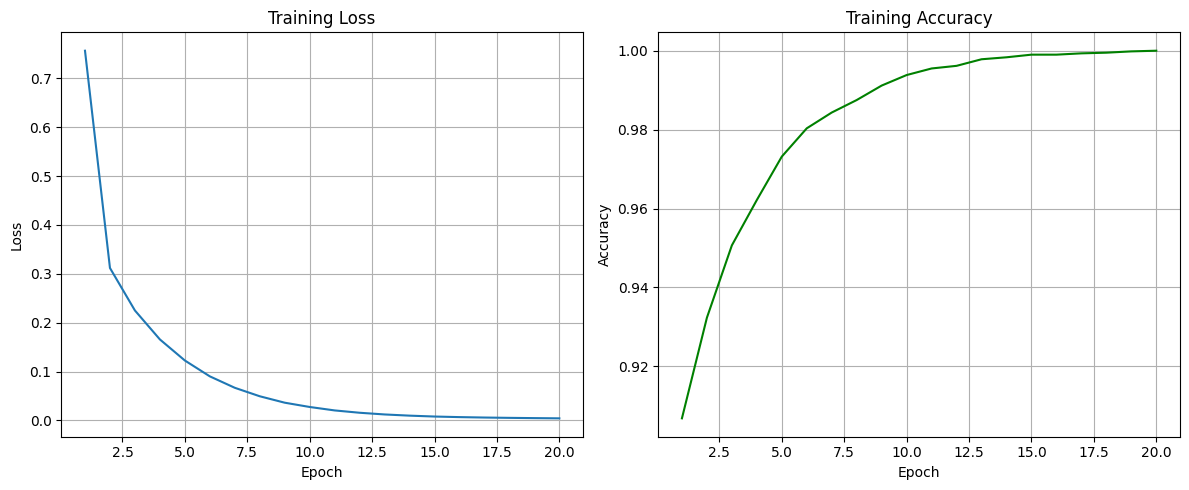

In [102]:
#Visualization
num_epoch = range(1, epochs+1)

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_epoch, loss_history, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_epoch, accuracy_history, label = 'accuracy', color = 'green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

---
We can see a fairly smooth decrease in the loss and a fairly smooth increase in the accuracy. The smoothness of the decrement of loss is an indicator of the fact that the learning rate chosen is good.

---

### Testing the model using the Test Dataset

In [143]:
test_accuracy = compute_accuracy(x_test, y_test_encoded)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9513


---
The model is now tested using the Test Dataset. This is the part of the original dataset which the model is seeing for the first time.

We have obtained a Final Test Accuracy of 0.9513 and the weights and biases for that particular case has been stored in a .pkl file. 

---

### To reset the weights 
(use this only to re-assign random values to the weights so that the model may be trained as if for the first time)

In [108]:
'''
# Reinitialize weights and biases
w1 = np.random.randn(hidden_size, input_size) * 0.01
b1 = np.zeros((hidden_size, 1))
w2 = np.random.randn(output_size, hidden_size) * 0.01
b2 = np.zeros((output_size, 1))
'''

'\n# Reinitialize weights and biases\nw1 = np.random.randn(hidden_size, input_size) * 0.01\nb1 = np.zeros((hidden_size, 1))\nw2 = np.random.randn(output_size, hidden_size) * 0.01\nb2 = np.zeros((output_size, 1))\n'

#### Saving Model Weights

---

To save the weights we have obtained for the best accuracy through training. These can be loaded later on if needed.

---

In [110]:
'''
import pickle

# Create a dictionary of model parameters
model_parameters = {
    'w1': w1,
    'b1': b1,
    'w2': w2,
    'b2': b2
}

# Save to a file
with open('mnist_model.pkl', 'wb') as f:
    pickle.dump(model_parameters, f)
'''

"\nimport pickle\n\n# Create a dictionary of model parameters\nmodel_parameters = {\n    'w1': w1,\n    'b1': b1,\n    'w2': w2,\n    'b2': b2\n}\n\n# Save to a file\nwith open('mnist_model.pkl', 'wb') as f:\n    pickle.dump(model_parameters, f)\n"

In [141]:
'''
import pickle
# Load from file
with open('mnist_model.pkl', 'rb') as f:
    loaded_parameters = pickle.load(f)

# Extract weights and biases
w1 = loaded_parameters['w1']
b1 = loaded_parameters['b1']
w2 = loaded_parameters['w2']
b2 = loaded_parameters['b2']
'''

---
### Results

#### Final Accuracy

The neural network obtained was an accuracy level of 95.13% after training for several epochs on a dataset of 10000 images. The weights and biases have been stored in a .pkl file and the necessary code needed to access it has been provided. This model was trained using a simple two-layer architecture with ReLU and Softmax activations and optimized using cross-entropy loss.

#### Observations

- Model showed rapid improvement in the initial epochs, with average loss steadily decreasing.
- Sparse activation from the ReLU layer appeared to help generalization.
- Softmax paired with cross-entropy loss provided stable training and a better convergence.

---
### Conclusions

#### What I Learned
- Implementing a neural network from scratch using Numpy alone helped me gain valuable insight and an intuitive understanding on how each component contributes to the training dynamics.
- Developed an understanding on the concepts of forward propagation, backward propagation, activation functions, and loss functions.
- Gained insight into the workings of weights, biases, and gradients and how they interact to update the network and improve accuracy.
- Learned how to visualize errors and test predictions during training.

#### Future Improvements
- Extend to batch training instead of individual samples to enable faster convergence.
- Add validation set monitoring to better generalize and avoid overfitting.
- Experiment with deeper architecture and alternate activation functions like Leaky ReLU.
- Use weights initialization techniques like Xavier or He Initialization for improved performance.

---